# Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import math
import pickle

import warnings
warnings.filterwarnings("ignore")

# Train-Test
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE

# Classification models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Tensorflow
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils.vis_utils import plot_model

2021-12-02 20:15:18.379946: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 20:15:18.379971: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load data from pickle file

In [2]:
df_train_processed = pd.read_pickle('./data/df_train_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

In [3]:
# Split into train/cv
X_train, X_cv, y_train, y_cv = train_test_split(
    df_train_processed.drop(['Potability'], axis=1),
    df_train_processed['Potability'],
    test_size=0.1,
    random_state=0,   
    stratify=df_train_processed['Potability'])

## Feature selection: PCA

In [4]:
explained_variance = .95
pca = PCA(n_components=explained_variance).fit(X_train)

X_train_pca = pca.transform(X_train)
X_cv_pca = pca.transform(X_cv)

print("Number of components required to explain "+str(explained_variance)+"% of the variance = "+str(X_train_pca.shape[1]))

Number of components required to explain 0.95% of the variance = 9


## Feature selection: RFE (with simple Logistic Regression)

In [5]:
logisticRegr = LogisticRegression()

rfe = RFE(estimator=logisticRegr, step=1, verbose=0, n_features_to_select=9)
rfe = rfe.fit(X_train, y_train.values.ravel())

total_cols = np.array(X_train.columns.values.tolist())
selected_cols = total_cols[rfe.support_].tolist()
X_train_rfe = X_train[selected_cols]
X_cv_rfe =  X_cv[selected_cols]
print("Columns selected: "+str(selected_cols))

Columns selected: ['Trihalomethanes_imputed', 'Sulfate', 'Hardness', 'Solids', 'Conductivity', 'Trihalomethanes', 'Turbidity', 'ph_imputed', 'Sulfate_imputed']


In [6]:
# Save data
open_file = open('./data/clf_pca.pkl', "wb")
pickle.dump(pca, open_file)
open_file.close()

open_file = open('./data/clf_rfe_cols.pkl', "wb")
pickle.dump(selected_cols, open_file)
open_file.close()

# Train Models

In [7]:
def testModel(clf_,grid_values_,X_train_,y_train_,X_cv_,y_cv_,scoring_='f1',verbose_=0):
    # model.get_params() # Return selected params
    # cv=None -> None, to use the default 5-fold cross validation (K-Fold, k=5)
    model_ = GridSearchCV(clf_, param_grid = grid_values_, cv=None, scoring=scoring_,verbose=verbose_)
    model_.fit(X_train_, y_train_)

    y_pred = model_.predict(X_cv_)
    metrics_={    
        "accuracy":         metrics.accuracy_score(y_cv_, y_pred),
        "precision":        metrics.precision_score(y_cv_, y_pred),
        "recall":           metrics.recall_score(y_cv_, y_pred),
        "f1_score":         metrics.f1_score(y_cv_, y_pred),
        "confusion_matrix": metrics.confusion_matrix(y_cv_, y_pred)
    }
    return model_, metrics_

def train_models(X_train_, y_train_, X_cv_, y_cv_, features_selection='',add_dummy=False):
    model_list=[]

    # Dummy Classifier
    if add_dummy:
        clf = DummyClassifier(strategy= 'most_frequent')
        grid_values={}
        model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
        model_list.append(
            {'name': 'DummyClassifier',
            'model': model,
            'features_selection': features_selection,
            'metrics': model_metrics
            }
        )

    # LogisticRegression
    clf = LogisticRegression()
    grid_values = {
        'penalty': ['l2',None],
        'C': [0.01,.1,1,10],
        }

    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'LogisticRegression',
        'model': model,
        'features_selection': features_selection,
        'metrics': model_metrics  
        }
    )

    # SGDClassifier
    # Linear classifiers (SVM, logistic regression, etc.) with SGD training. 
    # For best results using the default learning rate schedule, the data should have zero mean and unit variance.
    loss_list = [           # List of models
        'hinge',            # SVM
        'squared_hinge',    # Like hinge but quadratically penalized
    ]

    for loss in loss_list:
        grid_values = {
            'l1_ratio': [0,0.25,0.5,0.75,1], # (0 <= l1_ratio <= 1): l1_ratio=0 corresponds to L2 penalty, l1_ratio=1 to L1
            'alpha': [0.001, 0.01,.1,1], # The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’.
            }

        clf = SGDClassifier(verbose=0, max_iter=1000, tol=1e-3, penalty='elasticnet',
                            learning_rate='optimal', early_stopping=True, validation_fraction=0.1, 
                            n_iter_no_change=5, loss=loss)

        model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
        model_list.append(
            {'name': 'SGDClassifier_'+str(loss),
            'model': model,
            'features_selection': features_selection,
            'metrics': model_metrics    
            }
        )

    # DecisionTreeClassifier
    clf = DecisionTreeClassifier()
    grid_values = {}
    X_train_,y_train_,X_cv_,y_cv_ = X_train_pca, y_train, X_cv_pca, y_cv
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'DecisionTreeClassifier',
        'model': model,
        'features_selection': features_selection,
        'metrics': model_metrics    
        }
    )

    # RandomForestClassifier
    clf = RandomForestClassifier(criterion="entropy")
    grid_values = {}
    X_train_,y_train_,X_cv_,y_cv_ = X_train_pca, y_train, X_cv_pca, y_cv
    model, model_metrics = testModel(clf,grid_values,X_train_,y_train_,X_cv_,y_cv_)
    model_list.append(
        {'name': 'RandomForestClassifier',
        'model': model,
        'features_selection': features_selection,
        'metrics': model_metrics    
        }
    )

    return model_list

In [8]:
model_list_rfe = train_models(X_train_rfe, y_train, X_cv_rfe, y_cv, features_selection='RFE', add_dummy=True)
model_list_pca = train_models(X_train_pca, y_train, X_cv_pca, y_cv, features_selection='PCA')

model_list = model_list_pca+model_list_rfe

## Add Neural Network

In [9]:
def create_model():
  # create model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(100))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(30))
  model.add(tf.keras.layers.Activation('relu'))
  model.add(tf.keras.layers.Dense(1))
  model.add(tf.keras.layers.Activation('sigmoid'))

  return model

nn_model = create_model()

nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=[ tf.keras.metrics.AUC(),
              'accuracy',
    ]
)

nn_history = nn_model.fit(
    X_train.astype(np.float32), 
    y_train.astype(np.float32),
    epochs=70,
    batch_size=32,
    validation_data=(X_cv, y_cv),
    verbose=0
)

nn_y_pred = np.array(nn_model.predict(X_cv)>.5).squeeze().astype(int)
nn_metrics = {    
    "accuracy":         metrics.accuracy_score(y_cv, nn_y_pred),
    "precision":        metrics.precision_score(y_cv, nn_y_pred),
    "recall":           metrics.recall_score(y_cv, nn_y_pred),
    "f1_score":         metrics.f1_score(y_cv, nn_y_pred),
    "confusion_matrix": metrics.confusion_matrix(y_cv, nn_y_pred)
}

nn_metrics

2021-12-02 20:15:49.249209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-02 20:15:49.249572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-02 20:15:49.249630: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-12-02 20:15:49.249682: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-12-02 20:15:49.249735: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

{'accuracy': 0.6901840490797546,
 'precision': 0.6685393258426966,
 'recall': 0.7391304347826086,
 'f1_score': 0.7020648967551621,
 'confusion_matrix': array([[106,  59],
        [ 42, 119]])}

In [10]:
model_list.append(
    {'name': 'NeuralNetwork',
    'model': nn_model,
    'features_selection': "None",
    'metrics': nn_metrics    
    }
)

In [11]:
models_df = None
column_names = ["name","features_selection","accuracy","precision","recall","f1_score","confusion_matrix","model"]
models_df = pd.DataFrame(columns=column_names)
for m in model_list:
    m_append = []
    m_append.append(m["name"])
    m_append.append(m["features_selection"])
    m_append.append(m["metrics"]["accuracy"])
    m_append.append(m["metrics"]["precision"])
    m_append.append(m["metrics"]["recall"])
    m_append.append(m["metrics"]["f1_score"])
    m_append.append(m["metrics"]["confusion_matrix"])
    m_append.append(m["model"])
    m_series = pd.Series(m_append, index = models_df.columns)
    models_df = models_df.append(m_series, ignore_index=True)
models_df[['name','features_selection','accuracy','precision','recall','f1_score',"confusion_matrix"]]

,name,features_selection,accuracy,precision,recall,f1_score,confusion_matrix
0,LogisticRegression,PCA,0.518405,0.514286,0.447205,0.478405,"[[97, 68], [89, 72]]"
1,SGDClassifier_hinge,PCA,0.493865,0.493865,1.000000,0.661191,"[[0, 165], [0, 161]]"
2,SGDClassifier_log,PCA,0.506135,0.000000,0.000000,0.000000,"[[165, 0], [161, 0]]"
3,SGDClassifier_squared_hinge,PCA,0.487730,0.481013,0.472050,0.476489,"[[83, 82], [85, 76]]"
4,DecisionTreeClassifier,PCA,0.687117,0.654450,0.776398,0.710227,"[[99, 66], [36, 125]]"
5,RandomForestClassifier,PCA,0.720859,0.721519,0.708075,0.714734,"[[121, 44], [47, 114]]"
6,DummyClassifier,RFE,0.506135,0.000000,0.000000,0.000000,"[[165, 0], [161, 0]]"
7,LogisticRegression,RFE,0.496933,0.489655,0.440994,0.464052,"[[91, 74], [90, 71]]"
8,SGDClassifier_hinge,RFE,0.530675,0.633333,0.118012,0.198953,"[[154, 11], [142, 19]]"
9,SGDClassifier_log,RFE,0.521472,0.517007,0.472050,0.493506,"[[94, 71], [85, 76]]"


In [12]:
# Save
open_file = open('./data/clf_list.pkl', "wb")
pickle.dump(model_list, open_file)
open_file.close()

models_df.to_pickle('./data/clf_df.pkl')

# # Load
# open_file = open('./data/clf_list.pkl', "rb")
# model_list = pickle.load(open_file)
# open_file.close()

# models_df = pd.read_pickle('./data/clf_df.pkl')

2021-12-02 20:15:58.362074: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://f5e14c41-46f6-4857-83e4-07f4ef91d655/assets
INFO:tensorflow:Assets written to: ram://41a75de1-339d-49e3-a1bd-04fb73653cd0/assets


In [13]:
metrics_list=["accuracy","precision","recall","f1_score"]
for met in metrics_list:
    idx = models_df[met].argmax()
    name = models_df.iloc[idx]["name"] 
    features_selection = models_df.iloc[idx]["features_selection"]
    value = models_df.iloc[idx][met]
    print("best "+str(met)+" = "+"{:10.2f}".format(value)+":\t"+str(name)+" (features="+str(features_selection)+")")

best accuracy =       0.75:	RandomForestClassifier (features=RFE)
best precision =       0.75:	RandomForestClassifier (features=RFE)
best recall =       1.00:	SGDClassifier_hinge (features=PCA)
best f1_score =       0.74:	RandomForestClassifier (features=RFE)


# Final Test

In [14]:
# # Load Data
df_test_processed = pd.read_pickle('./data/df_test_processed.pkl')

open_file = open('./data/df_param_dict.pkl', "rb")
param_dict = pickle.load(open_file)
open_file.close()

open_file = open('./data/clf_pca.pkl', "rb")
pca = pickle.load(open_file)
open_file.close()
open_file = open('./data/clf_rfe_cols.pkl', "rb")
selected_cols = pickle.load(open_file)
open_file.close()

open_file = open('./data/clf_list.pkl', "rb")
model_list = pickle.load(open_file)
open_file.close()

models_df = pd.read_pickle('./data/clf_df.pkl')

In [15]:
# # # Remove NaN (no needed)
df_test_processed = df_test_processed[df_test_processed['Potability'].notna()]

# Split X, y
X_test = df_test_processed.drop(['Potability'],axis=1)
y_test = df_test_processed.Potability

# Select and print best_model
print('Best model: '+str(models_df.iloc[models_df['f1_score'].argmax()]['name'])+ " (" \
    + str(models_df.iloc[models_df['f1_score'].argmax()]['features_selection'])+")")
best_model = models_df.iloc[models_df['f1_score'].argmax()]['model']
best_features_selection = models_df.iloc[models_df['f1_score'].argmax()]["features_selection"]

Best model: RandomForestClassifier (RFE)


In [16]:
if best_features_selection == 'PCA':
    # Transform PCA
    X_test_trf = pca.transform(X_test)
    print("Using PCA")
else:
    # Transform RFE
    X_test_trf = X_test[selected_cols]
    print("Using RFE")

# Predict
y_pred = best_model.predict(X_test_trf)

# Get metrics
test_metrics={    
    "accuracy":         metrics.accuracy_score(y_test, y_pred),
    "precision":        metrics.precision_score(y_test, y_pred),
    "recall":           metrics.recall_score(y_test, y_pred),
    "f1_score":         metrics.f1_score(y_test, y_pred),
    "confusion_matrix": metrics.confusion_matrix(y_test, y_pred)
}

test_metrics

Using RFE


{'accuracy': 0.5017064846416383,
 'precision': 0.484375,
 'recall': 0.2152777777777778,
 'f1_score': 0.2980769230769231,
 'confusion_matrix': array([[232,  66],
        [226,  62]])}

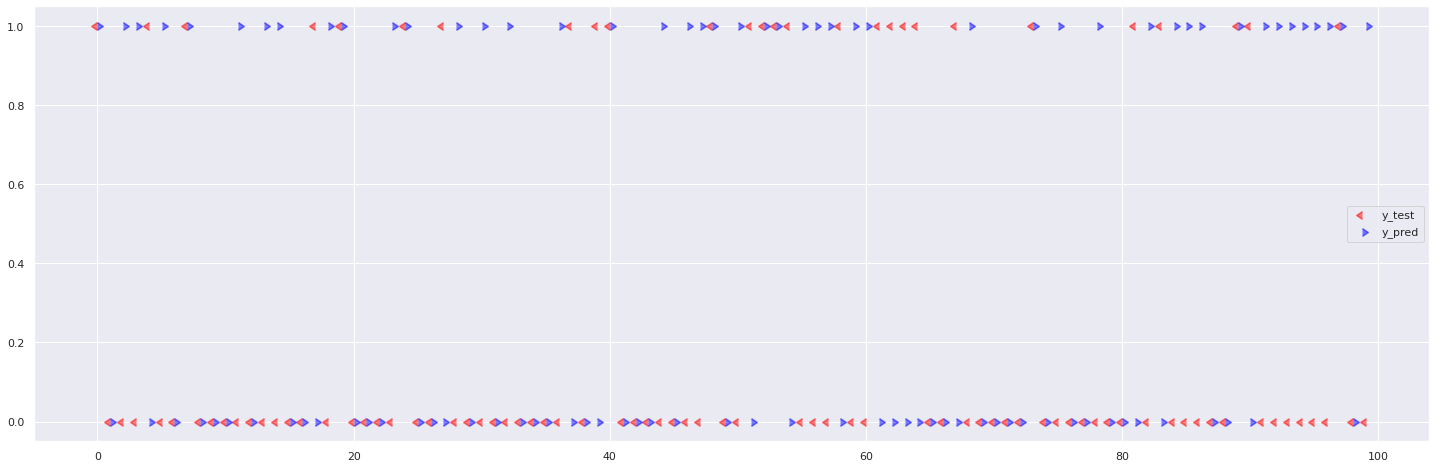

In [17]:
TRUNC = 100 #-1: do not trunc
x = np.linspace(0,y_test.shape[0]-1,y_test.shape[0])
plt.figure(figsize=(25,8))
plt.scatter(x[0:TRUNC],y_pred[0:TRUNC],color='red',alpha=.5, marker=8,s=60, label="y_test")
plt.scatter(x[0:TRUNC],y_test[0:TRUNC],color='blue',alpha=.5, marker=9,s=60, label="y_pred")
plt.legend()